In [1]:
import tensorflow as tf
from tensorflow import keras as ks
import abc
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
import fun.net_koopman as net
print(tf.config.list_physical_devices('GPU'))  # 确认GPU可用


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# According to https://blog.csdn.net/hxj0323/article/details/121629067
# Implement GPU memory allocation according to demand
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0 :
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("Got no GPUs")

In [3]:
# load and prepare data 
x_train = np.load('data/kw-state35-gamma-c/kw-s35-gamma-c-train-9-7.npy')
x_val = np.load('data/kw-state35-gamma-c/kw-s35-gamma-c-val-9-7.npy')
x_test = np.load('data/kw-state35-gamma-c/kw-s35-gamma-c-test-9-7.npy')

x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train_list = []
for i in range(5):
    x_train_list.append(x_train[:, i*20:(i+1)*20, :])
del x_train
x_train = np.concatenate(x_train_list, )

print(x_train.shape, x_val.shape, x_test.shape)

(30520, 20, 360) (2015, 100, 360) (2035, 500, 360)


In [4]:
# Neural network hyperparameters

# the name of the project
# deep koopman wave prediction trained under random sea state 3-5 
space_name = 'dKWP-s35'       
name_base = 'dKWP-s5-dt04'      

act_f = 'elu'
# the time step in training set, or N_s in the paper
sp = 15
TIME_END = 5 * 60 * 60 
batch_size = 64
learning_rate = 0.0001

# the dimension of the model input-output 
output_shape = x_val.shape[-1] 
inputs_shape = output_shape 
# the dimension of the latent space, or the dimension of the z_k in the paper
z_dim = 450
# 
time_now = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())).replace(' ', '-').replace(':', '-')
name = name_base +'-act_f-'+ act_f  + '-sp-' + str(sp) + '-z-' + str(z_dim) 
MODEL_NAME = name  + '-' + time_now
# 设置结果保存路径
pdf_path = 'pdf_diff_zdim_v2/'

print("model name ", MODEL_NAME)
# number of each layer in the encoder and decoder
h_state = int(3 * inputs_shape)
encoder_list = [inputs_shape, h_state, h_state, z_dim]
decoder_list = [z_dim, h_state, h_state, output_shape]

# parameter of the early stopping
patience = 10000
wait = 0 
best = 1



model name  dKWP-s5-dt04-act_f-elu-sp-15-z-450-2024-10-16-16-50-24


In [5]:
# the settings of the saving of the models and the tensorboard

# save path of the model
SAVE_PATH_ENCODER =  './models/' + space_name + '/' + MODEL_NAME + '/encoder'
SAVE_PATH_DECODER =  './models/' + space_name + '/' + MODEL_NAME + '/decoder'
SAVE_PATH_K_MATRIX =  './models/' + space_name + '/' + MODEL_NAME + '/kmatrix'

# save path of the tensorboard 
TRAIN_LOG_DIR = './log/' + space_name + '/' + MODEL_NAME + '/train'
VAL_LOG_DIR = './log/' + space_name + '/'+ MODEL_NAME + '/val'

# Initialize the model
encoder = net.Mlp(encoder_list, act_fun=act_f, name='encoder')
koopman_op = net.Koopman(shape=encoder_list[-1])
decoder = net.Mlp(decoder_list, act_fun=act_f, name='decoder')

# settings about the saving model
ckpt_encoder = tf.train.Checkpoint(step=tf.Variable(0), net=encoder) 
ckpt_decoder = tf.train.Checkpoint(step=tf.Variable(0), net=decoder) 
ckpt_k_matrix = tf.train.Checkpoint(step=tf.Variable(0), net=koopman_op) 

manager_encoder = tf.train.CheckpointManager(ckpt_encoder, SAVE_PATH_ENCODER, max_to_keep=3)
manager_decoder = tf.train.CheckpointManager(ckpt_decoder, SAVE_PATH_DECODER, max_to_keep=3)
manager_k_matrix = tf.train.CheckpointManager(ckpt_k_matrix, SAVE_PATH_K_MATRIX, max_to_keep=3)

op_adam = tf.keras.optimizers.Adam(learning_rate)

# tensorboard settings
train_summary_writer = tf.summary.create_file_writer(TRAIN_LOG_DIR)
val_summary_writer = tf.summary.create_file_writer(VAL_LOG_DIR)




encoder [360, 1080, 1080, 450]
decoder [450, 1080, 1080, 360]


In [6]:
# The parameter i used to record how many times the model loops is used
i = 0 
# Get the current time
time_start = time.time()

while time.time() - time_start < TIME_END:
    
    with tf.GradientTape(persistent=True) as tape:
        # Randomly select a portion of the data as training data and update the model parameters
        index = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
        index = np.unique(index)
        y_dict = net.koopman_model(x_train[index, :, :], encoder, decoder, koopman_op, sp-1)
        loss_dict = net.loss_fun_model(x_train[index, :, :], y_dict, sp=sp-1)

        e_gradients = tape.gradient(loss_dict['loss_all'], encoder.trainable_variables)
        op_adam.apply_gradients(zip(e_gradients, encoder.trainable_variables))
        e_gradients = tape.gradient(loss_dict['loss_all'], decoder.trainable_variables)
        op_adam.apply_gradients(zip(e_gradients, decoder.trainable_variables))
        e_gradients = tape.gradient(loss_dict['loss_all'], koopman_op.trainable_variables)
        op_adam.apply_gradients(zip(e_gradients, koopman_op.trainable_variables))

        # Verification set error
        index_val = np.random.randint(low=0, high=x_val.shape[0], size=batch_size)
        index_val = np.unique(index_val)    

        y_valid = net.koopman_model(x_val[index_val, :, :], encoder, decoder, koopman_op, sp=sp-1)
        loss_val_dict = net.loss_fun_model(x_val[index_val, :, :], y_valid, sp=sp-1)
        
        # The early stopping strategy: stop the training if `val_loss` does not
        # decrease over a certain number of epochs.
        wait += 1
        if loss_val_dict['loss_all'].numpy() < best:
            best = loss_val_dict['loss_all'].numpy()
            wait = 0
        if wait >= patience:
            print(wait, best)
            break

        # Record the process of error reduction to tensorboard
        net.tensor_board_summary_writer(train_summary_writer, loss_dict, i)
        net.tensor_board_summary_writer(val_summary_writer, loss_val_dict, i)           
        i = i + 1 

# save the model  
save_path = manager_encoder.save()
save_path = manager_decoder.save()
save_path = manager_k_matrix.save()

10000 7.220374e-05


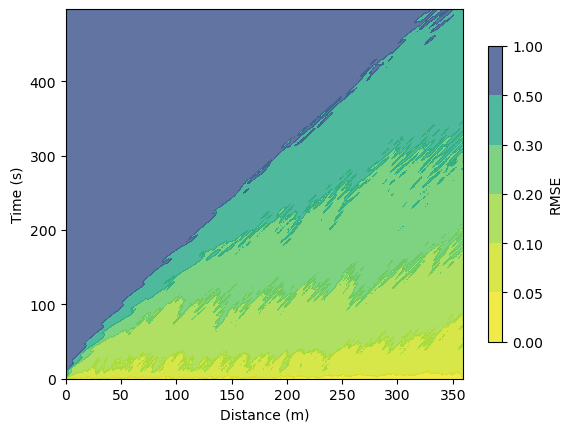

In [7]:
# mse in each time step
sp = 499
y_test_list = []

for i in range(x_test.shape[0]):
    y_test_ = net.koopman_model(x_test[i:(i + 1), :, :], encoder, decoder, koopman_op, sp=sp - 1)
    y_test_list.append(y_test_['x_recon_mult_shift'].numpy())


rmse_sp = np.zeros(shape=[output_shape, sp - 1])
for i in range(int(sp - 1)):
    mse = 0
    for j in range(x_test.shape[0]):

        mse = mse + np.sum(np.square(x_test[j:(j + 1), i + 1, :] - y_test_list[j][:, i, :]), axis=0)
    rmse = np.sqrt(mse / x_test.shape[0])
    rmse_sp[:, i] = rmse


plt.contourf(rmse_sp.T, cmap="viridis_r", alpha=0.8, levels=[0, 0.05, 0.1, 0.2, 0.3, 0.5, 1])
plt.colorbar(shrink=0.8, )
plt.ylabel('Time (s)')
plt.xlabel('Distance (m)')
plt.show()

(450,) <class 'numpy.ndarray'> (450, 450) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'random sea state hos Eigenvalue K dim=450')

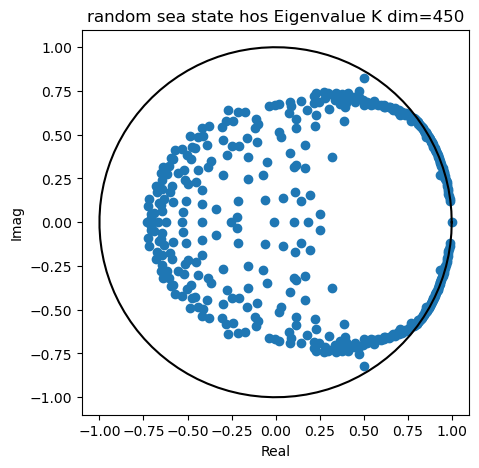

In [8]:
# Calculate the eigenvalues of the Koopman operator

K = koopman_op.k_matrix.numpy()
eigenvalues, eigenvectors = np.linalg.eig(K)

theta = np.linspace(0, 2*np.pi, 100)

radius = 1

a = radius*np.cos(theta)
b = radius*np.sin(theta)

print(eigenvalues.shape,type(eigenvalues), eigenvectors.shape, type(eigenvectors))
plt.figure(figsize=(5,5))
plt.scatter(eigenvalues.real, eigenvalues.imag, )
plt.plot(a, b, 'black',)
# plt.xticks([-.5, 0, 0.5, 0.6, 0.8, 1.0])
plt.xlabel("Real")
plt.ylabel('Imag')
plt.title('random sea state hos Eigenvalue K dim=%d'%z_dim)

# save the relusts as pdf
# plt.savefig(pdf_path + MODEL_NAME + '.jpg', dpi=300, bbox_inches='tight')
# plt.title('random sea state hos K dim=%d'%z_dim)
# plt.contourf(K, cmap="viridis_r", alpha=0.8, )
# plt.colorbar(shrink=0.8, )
